# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22400)

In [7]:
Vout

array([[-0.02864093, -0.02855869, -0.02865738, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02885476, -0.02873963, -0.02862449, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02819682, -0.02829552, -0.02832841, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02579534, -0.02564731, -0.02572955, ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02441367, -0.02439722, -0.02418339, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.021272  , -0.02135425, -0.02138714, ..., -0.02329517,
        -0.02314713, -0.02311424]])

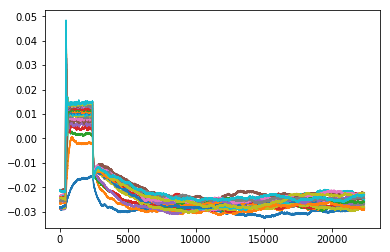

In [8]:
plot(Vout.transpose());

#### Get positive injection current

In [9]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

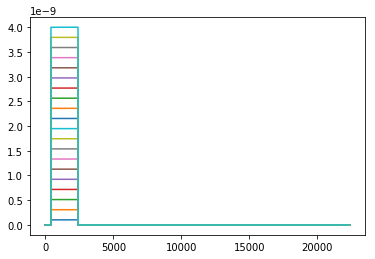

In [10]:
plot(Ic.transpose());

#### Get white noise injection

In [11]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

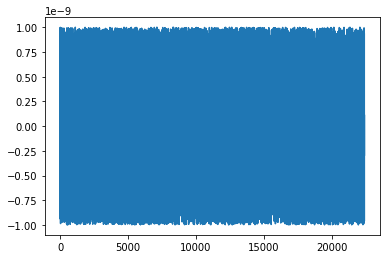

In [12]:
plot(Inoise);

#### Get V from white noise

In [13]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

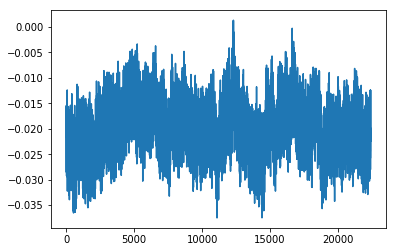

In [14]:
plot(Vnoise);

### Concatinate the data

In [15]:
np.shape(Vnoise)

(22400,)

In [16]:
np.shape(Vout)

(20, 22400)

In [17]:
output = np.concatenate((Vout, [Vnoise]))
np.shape(output)

(21, 22400)

In [18]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(21, 22400)

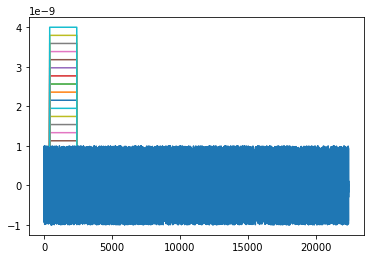

In [19]:
plot(input_cur.transpose());

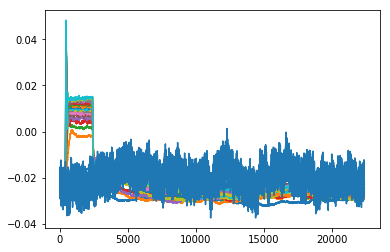

In [20]:
plot(output.transpose());

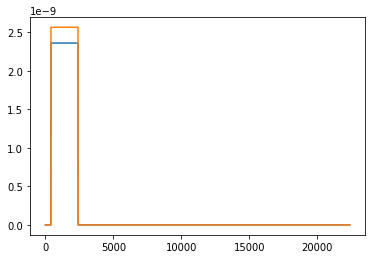

In [21]:
plot(input_cur[11:13].transpose())

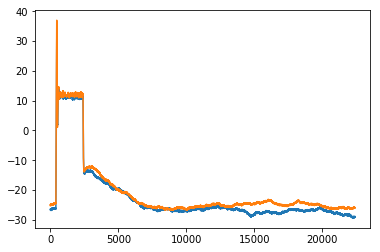

In [22]:
plot((output[11:13]/1e-3).transpose());

## Build a model

In [23]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
# C = 130*pF,
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)
# gL = 1/142*1/Mohm)

In [24]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [25]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

In [29]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
# C = 300*pF,
# EL = -30*mV,
# gL = 1/50*1/Mohm
)

In [ ]:
params, fits, error = fit_traces_de(model = model, input_var = 'I', output_var = 'v',\
        input=input_cur * amp, output=output/1e-3 * volt, dt=dt,
        method='exponential_euler',
        EL=[-50*mV, -10*mV],
        C=[100*pF, 400*pF],
        gL=[7*nS, 20*nS],                        
        g_k=[10e-9*siemens, 10e2*siemens],
        kn = [5*mV, 20*mV],
        Vn = [-20*mV, 20*mV],
        Ek = [-100*mV, 0*mV],                   
        taun=[10e-2*ms, 100*ms],
        popsize=20)

INFO       No numerical integration method specified, using method 'exponential_euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


differential_evolution step 1: f(x)= 583.489
differential_evolution step 2: f(x)= 583.489
differential_evolution step 3: f(x)= 583.331
differential_evolution step 4: f(x)= 583.289
differential_evolution step 5: f(x)= 583.289
differential_evolution step 6: f(x)= 583.251
differential_evolution step 7: f(x)= 583.251
differential_evolution step 8: f(x)= 583.249
differential_evolution step 9: f(x)= 583.249
differential_evolution step 10: f(x)= 583.249
differential_evolution step 11: f(x)= 583.246
differential_evolution step 12: f(x)= 583.23
differential_evolution step 13: f(x)= 583.23
differential_evolution step 14: f(x)= 583.23
differential_evolution step 15: f(x)= 583.23
differential_evolution step 16: f(x)= 583.23
differential_evolution step 17: f(x)= 583.23
differential_evolution step 18: f(x)= 583.229
differential_evolution step 19: f(x)= 583.229
differential_evolution step 20: f(x)= 583.229
differential_evolution step 21: f(x)= 583.229
differential_evolution step 22: f(x)= 583.229
dif

In [35]:
params

{'C': 1.0000204034721506e-10,
 'g_k': 998.1854096872182,
 'taun': 0.0009681673507459937,
 'Vn': -0.01995737702493305,
 'Ek': -0.09999999987310619,
 'kn': 0.019998002942531706,
 'EL': -0.04999836647875873,
 'gL': 1.999859778875419e-08}

In [36]:
error

24.15010368 * volt

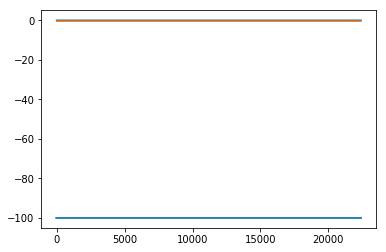

In [44]:
plot((fits/mV).transpose())